# Instructions for getting dataframe from RDS

```
get_batch_data(
    base_coin='ETH',
    quote_coin='BTC',
    start_time='2021-01-01',                  #YYYY-MM-DD
    end_time='2021-07-01',                    #YYYY-MM-DD
    columns=['close','close_30','close_100'], # any valid features with `_x` suffix support
    batch_size=1000000,                       # Large number to get everything
    extra_rows=10,                            # Fetch extra rows for custom feature engineering
    use_cache=False,                          # Cache can be used when current time > end_time
)

VALID_FEATURES = [
    'pair_id','open_time','close_time','dow','tod',
    'open','high','low','close',
    'number_of_trades','volume','quote_asset_volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
    'ma14','ma30','ma90',
    'sup14','sup30','sup90',
    'res14','res30','res90',
    'atr','atr_diff','atr_ma14',
    'rsi','rsi_diff','rsi_ma14',
    'trend_up','trend_up3','trend_up14','trend_up30',
    'cs_ss','cs_ssr','cs_hm','cs_hmr','cs_brh','cs_buh','cs_ebu','cs_ebr'
]
```

# Instructions for Manual Simulation

1. Decide on a name for your model.  Add first letter of your name and numbers as prefix  For example: `t0_dummy`.
2. Create a `.py` file with the name of your model in the `trade_models` directory (`./trade_models/t0_dummy.py`)
3. Import your model in `./trade_models/__init__.py` by adding `from . import t0_dummy`
4. Place any pre-trained models or scalers into the `./trade_models/assets/` directory with your model name as prefix.
5. Configure portfolio in the following cells.
    1. For `max_batch_size`, it is purely for memory considerations.  It does an SQL query per batch, so don't make it too small.
    2. Parameters inside portfolios are accessible inside the trade models
6. Run all

Sample portfolio (all fields must exist)
```
    {
        # Common parameters
        'portfolio_name' : f'ETH <-> BTC t0_dummy no fees',
        'trade_model' : 't0_dummy',      # name of the model to use
        'starting_coin' : 'ETH',         # aka the "base" coin
        'pair_coin' : 'BTC',             # aka the "quote" coin
        'max_batch_size' : 10000,        # how many entries to process per batch
        'starting_funds' : 16,           # amount of funds for starting coin
        'trading_fees_percent' : 0.1,    # trading fees in percent (0.1%)
        'trading_fees_buy' : 0.005,      # (0.005 ETH transaction fee to buy BTC)
        'trading_fees_sell' : 0.0004,    # (0.0004 BTC transaction fee to sell back to ETC)

        # Optional model specific parameteres
        'parameter_sample' : 'test',     # these variables are accessible in your model
    }
```

In [1]:
start_simulation = '2021-01-01' #YYYY-MM-DD
end_simulation = '2021-07-27' #YYYY-MM-DD

portfolios = [
    {
        'portfolio_name' : f'NM_ETHBTC_GradBoost_alpha1',
        'trade_model' : 'n0_alpha1',
        'model_filepath': 'trade_models/assets/nm_grad_boost_ethbtc_2107261356.pkl',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'extra_rows' : 0,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0,
        'trading_fees_sell' : 0,
    },
    {
        'portfolio_name' : f'NM_ETHBTC_XGBoost_alpha1',
        'trade_model' : 'n0_alpha1',
        'model_filepath': 'trade_models/assets/nm_xgb_ethbtc_2107271617.pkl',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'extra_rows' : 0,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0,
        'trading_fees_sell' : 0,
    },
#     {
#         'portfolio_name' : f'ETH <-> BTC XGBoost',
#         'trade_model' : 'n0_alpha2',
#         'model_filepath': 'trade_models/assets/nm_xgb_ethbtc_2107271617.pkl',
#         'starting_coin' : 'ETH',
#         'pair_coin' : 'BTC',
#         'max_batch_size' : 10000,
#         'extra_rows' : 0,
#         'starting_funds' : 1,
#         'trading_fees_percent' : 0.1,
#         'trading_fees_buy' : 0,
#         'trading_fees_sell' : 0,
#     },
]

# STOP

You shouldn't need to modify anything below this cell

# CODE FOR SIMULATION STARTS

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import re
from datetime import datetime
import pytz
import re
from operator import itemgetter

# models
import trade_models

VALID_FEATURES = [
    'pair_id','open_time','close_time','dow','tod',
    'open','high','low','close',
    'number_of_trades','volume','quote_asset_volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
    'ma14','ma30','ma90',
    'sup14','sup30','sup90',
    'res14','res30','res90',
    'atr','atr_diff','atr_ma14',
    'rsi','rsi_diff','rsi_ma14',
    'trend_up','trend_up3','trend_up14','trend_up30',
    'cs_ss','cs_ssr','cs_hm','cs_hmr','cs_brh','cs_buh','cs_ebu','cs_ebr'
]

In [4]:
# local postgres connection only
import hidden
sql_string = hidden.psycopg2(hidden.secrets())
print('PostgreSQL connection data taken from hidden.py')

# Make the connection and cursor
conn = psycopg2.connect(sql_string, connect_timeout=3)

PostgreSQL connection data taken from hidden.py


In [5]:
# validate inputs and portfolio parameters

def validate(date_text):
    try:
        datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
# validate start / end string format input to protect against injection
validate(start_simulation)
validate(end_simulation)

for p in portfolios:
    # validate symbol
    assert re.match('^[A-Z]{2,}$', p['starting_coin']), f"{p['starting_coin']} is invalid starting coin"
    assert re.match('^[A-Z]{2,}$', p['pair_coin']), f"{p['pair_coin']} is invalid pair coin"

    # validate starting funds
    assert p['starting_funds'] > 0, "Starting funds for must be > 0"

    # validate fees
    assert p['trading_fees_percent'] >= 0, "Trading Fees % for must be >= 0%"
    assert p['trading_fees_percent'] < 100, "Trading Fees % for must be < 100%"
    assert p['trading_fees_buy'] >= 0, "Trading Fees (buy) for must be >= 0"
    assert p['trading_fees_sell'] >= 0, "Trading Fees (sell) for must be >= 0"

    # validate batch size
    assert (isinstance(p['max_batch_size'], int) and p['max_batch_size'] > 0), f"{p['max_batch_size']} is not a valid batch size"

    # maybe we should validate model names too!
    # TODO: validate model names

In [6]:
# These are only used for caching
import hashlib
import pickle

def get_batch_data(base_coin, quote_coin, start_time, end_time, columns, batch_size=10000, extra_rows=0, use_cache=True):
    column_info = [(x,) + re.match('^(?P<feature>[a-z][a-z0-9]*(?:_[a-z][a-z0-9]*)*)(?:_(?P<shift>[0-9]{1,3}))?$',x).groups() for x in columns]
    max_lookback = max([(0 if x==None else int(x)) for _,_,x in column_info])
    s = base_coin+quote_coin+f"{start_time}"+f"{end_time}"+"".join(columns)+str(batch_size)+str(extra_rows)
    h = hashlib.md5(s.encode('utf-8')).hexdigest()
    should_use_cache = use_cache and (datetime.strptime(end_time, '%Y-%m-%d') < datetime.now(pytz.timezone('UTC')).replace(tzinfo=None))
    if should_use_cache:
        # Can use cache
        try:
            with open(f'./cache_data/{h}.pkl', 'rb') as fp:
                print(f"Using cache file: ./cache_data/{h}.pkl")
                return pickle.load(fp)
        except:
            print(f"No cache found")
            pass

    sql = f"""
select
    f.*, open_time, open, high, low, close, volume, close_time, quote_asset_volume, number_of_trades, taker_buy_base_asset_volume, taker_buy_quote_asset_volume	
from
    (
        (select * from (select id as the_pair from pairs p where p.coin1='{base_coin}' and p.coin2='{quote_coin}') z inner join candlestick_15m on the_pair=pair_id where close_time notnull and open_time < '{start_time}' order by open_time desc limit {max_lookback + extra_rows})
            union all
        (select * from (select id as the_pair from pairs p where p.coin1='{base_coin}' and p.coin2='{quote_coin}') z inner join candlestick_15m on the_pair=pair_id where close_time notnull and open_time between '{start_time}' and '{end_time}' order by open_time limit {batch_size})
    ) cm
inner join 
    features f on f.pair_id = cm.pair_id and f.candle_open_time = cm.open_time
order by
    open_time desc
"""
    base_df = pd.read_sql_query(sql, conn)
    df = base_df[['candle_open_time']].copy()
    for name, feature, shift in column_info:
        assert feature in VALID_FEATURES, f"Invalid feature: {feature} for {name}"
        df[name] = base_df[feature].shift((0 if shift==None else -int(shift)))
        
    if extra_rows == 0:
        extra_df = None
    else:
        extra_df = df.copy()
        extra_df['is_extra'] = ~extra_df['candle_open_time'].between(start_time, end_time)
        extra_df = extra_df.set_index('candle_open_time').sort_index()
        
    df = df[df['candle_open_time'].between(start_time, end_time)]
    df = df.set_index('candle_open_time').sort_index()

    ref_df = base_df[['open_time','open', 'high', 'low', 'close']].copy()
    ref_df = ref_df[ref_df['open_time'].between(start_time, end_time)]
    ref_df = ref_df.set_index('open_time').sort_index()

    batch_close_time = base_df['close_time'].max()
    
    if should_use_cache:
        with open(f'./cache_data/{h}.pkl', 'wb') as fp:
            print(f"Saving cache to: ./cache_data/{h}.pkl")
            pickle.dump((df, ref_df, extra_df, batch_close_time), fp, protocol=4)

    return df, ref_df, extra_df, batch_close_time

In [7]:
def simulate_portfolio(start_time, end_time, portfolio):
    portfolio_name = portfolio['portfolio_name']
    trade_model = portfolio['trade_model']
    starting_coin = portfolio['starting_coin']
    pair_coin = portfolio['pair_coin']
    max_batch_size = portfolio['max_batch_size']
    extra_rows = portfolio['extra_rows']
    starting_funds = portfolio['starting_funds']
    fee_multiplier = 1.0 - portfolio['trading_fees_percent'] / 100
    trading_fees_buy = portfolio['trading_fees_buy']
    trading_fees_sell = portfolio['trading_fees_sell']
    
    model = trade_models.__dict__[trade_model]
    columns = model.columns()

    current_time = start_time
    all_output = []
    
    info_dict = {'portfolio':portfolio}

    while True:
        print("next batch: ", current_time, end=": ")
        batch_data, ref_data, extra_data, batch_close_time = get_batch_data(starting_coin, pair_coin, current_time, end_time, columns, max_batch_size, extra_rows, True)
        if len(batch_data) == 0:
            break

        # Replace any boolean or object columns as int
        for col in batch_data.columns:
            if batch_data[col].dtype.kind in ['b','O']:
                batch_data[col] = batch_data[col].astype(int)
            
        batch_model_decision = model.make_decision(batch_data[columns], extra_data, info_dict)

        ref_data['trade_decision'] = batch_model_decision.values

        all_output.append(ref_data)
        current_time = batch_close_time

    results = pd.concat(all_output)
    
    results[['fund1','fund2','action']] = np.nan
    cur_funds = [starting_funds,0]
    results.iloc[0, results.columns.get_loc('fund1')] = starting_funds
    results.iloc[0, results.columns.get_loc('fund2')] = 0

    print("...Simulating actions...")
    
    for x,r in results.iterrows():
        if cur_funds[0] > 0:
            if r['trade_decision'] == 1:
                cur_funds[1] = ((cur_funds[0]-trading_fees_buy) * r['close']) * fee_multiplier
                cur_funds[0] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'action'] = 'buy'
        else:
            if r['trade_decision'] == -1:
                cur_funds[0] = ((cur_funds[1]-trading_fees_sell) / r['close']) * fee_multiplier
                cur_funds[1] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'action'] = 'sell'
    results[['fund1','fund2']] = results[['fund1','fund2']].ffill()
    results['total_value'] = results['fund1'] + results['fund2'] / results['close']
    results['action'] = results['action'].fillna('none')
    return portfolio_name, results

# START OF SIMULATION

In [8]:
simulation_results = {}

for p in portfolios:
    print(f"\"{p['portfolio_name']}\"")
    %time name, res = simulate_portfolio(start_simulation, end_simulation, p)
    simulation_results[name] = res
    print(f"Final value: {res.iloc[-1,-1]}\n\n")

"NM_ETHBTC_GradBoost_alpha1"
next batch:  2021-01-01: Using cache file: ./cache_data/584434beddf4517121aaa4f401e16bad.pkl
next batch:  2021-04-15 06:44:59.999000: Using cache file: ./cache_data/29e42daed725ce092b0017597272ebe3.pkl
next batch:  2021-07-27 00:14:59: Using cache file: ./cache_data/fb0d546e080e9b823f0922a8534b0689.pkl
...Simulating actions...
Wall time: 5.06 s
Final value: 0.28818272963419267


"NM_ETHBTC_XGBoost_alpha1"
next batch:  2021-01-01: Using cache file: ./cache_data/584434beddf4517121aaa4f401e16bad.pkl
next batch:  2021-04-15 06:44:59.999000: Using cache file: ./cache_data/29e42daed725ce092b0017597272ebe3.pkl
next batch:  2021-07-27 00:14:59: Using cache file: ./cache_data/fb0d546e080e9b823f0922a8534b0689.pkl
...Simulating actions...
Wall time: 2.67 s
Final value: 0.31342233511663337




# END OF SIMULATION

In [9]:
for k,v in simulation_results.items():
    print(k)
    print(f"Portfolio simulation for {p['starting_funds']} {p['starting_coin']} trading against {p['pair_coin']}")
    display(v[v['action']!='none'])
    display(v['action'].value_counts())

NM_ETHBTC_GradBoost_alpha1
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2021-01-01 01:30:00,0.025258,0.025492,0.025246,0.025482,1,0.000000,0.025457,buy,0.999000
2021-01-01 08:15:00,0.025282,0.025299,0.025100,0.025149,-1,1.011216,0.000000,sell,1.011216
2021-01-01 08:45:00,0.025095,0.025183,0.025084,0.025174,1,0.000000,0.025431,buy,1.010204
2021-01-01 11:30:00,0.025217,0.025266,0.025192,0.025232,-1,1.006874,0.000000,sell,1.006874
2021-01-01 15:15:00,0.025114,0.025253,0.025110,0.025243,1,0.000000,0.025391,buy,1.005868
...,...,...,...,...,...,...,...,...,...
2021-07-26 19:00:00,0.059954,0.060062,0.059446,0.059643,1,0.000000,0.017415,buy,0.291984
2021-07-26 19:15:00,0.059641,0.060063,0.059590,0.060031,-1,0.289807,0.000000,sell,0.289807
2021-07-26 20:00:00,0.060019,0.060222,0.059512,0.059560,1,0.000000,0.017244,buy,0.289517


none    18606
buy       610
sell      609
Name: action, dtype: int64

NM_ETHBTC_XGBoost_alpha1
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2021-01-01 01:30:00,0.025258,0.025492,0.025246,0.025482,1,0.000000,0.025457,buy,0.999000
2021-01-01 08:15:00,0.025282,0.025299,0.025100,0.025149,-1,1.011216,0.000000,sell,1.011216
2021-01-02 01:30:00,0.024651,0.024861,0.024639,0.024843,1,0.000000,0.025097,buy,1.010204
2021-01-02 02:15:00,0.024885,0.024933,0.024852,0.024933,-1,1.005551,0.000000,sell,1.005551
2021-01-02 06:30:00,0.024682,0.024850,0.024677,0.024848,1,0.000000,0.024961,buy,1.004546
...,...,...,...,...,...,...,...,...,...
2021-07-26 01:00:00,0.061474,0.061550,0.058669,0.060378,1,0.000000,0.019340,buy,0.320314
2021-07-26 06:00:00,0.060870,0.061355,0.060812,0.061277,-1,0.315299,0.000000,sell,0.315299
2021-07-26 20:00:00,0.060019,0.060222,0.059512,0.059560,1,0.000000,0.018760,buy,0.314984


none    19036
buy       395
sell      394
Name: action, dtype: int64

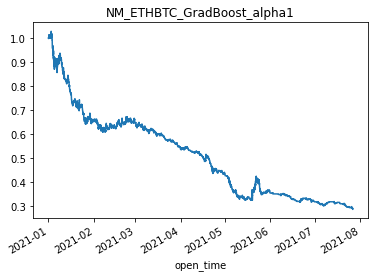

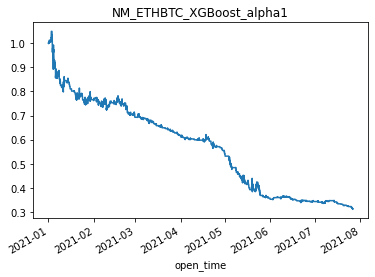

In [10]:
import matplotlib.pyplot as plt
for k,v in simulation_results.items():
    v[v['action']!='none'].to_csv(f'./results/{k}.csv')
    fig, ax = plt.subplots()
    ax.set_title(k)
    v.total_value.plot(figure=fig)

# Further Analysis

In [18]:
df = simulation_results['NM_ETHBTC_GradBoost_alpha1']

In [23]:
df[df.action !='none'].loc['2021-01-01']

,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2021-01-01 01:30:00,0.025258,0.025492,0.025246,0.025482,1,0.000000,0.025457,buy,0.999000
2021-01-01 08:15:00,0.025282,0.025299,0.025100,0.025149,-1,1.011216,0.000000,sell,1.011216
2021-01-01 08:45:00,0.025095,0.025183,0.025084,0.025174,1,0.000000,0.025431,buy,1.010204
2021-01-01 11:30:00,0.025217,0.025266,0.025192,0.025232,-1,1.006874,0.000000,sell,1.006874
2021-01-01 15:15:00,0.025114,0.025253,0.025110,0.025243,1,0.000000,0.025391,buy,1.005868
2021-01-01 17:00:00,0.025112,0.025125,0.025078,0.025092,-1,1.010909,0.000000,sell,1.010909


(<Figure size 800x575 with 2 Axes>,
  <matplotlib.axes._axes.Axes at 0x1dd914e52e0>])

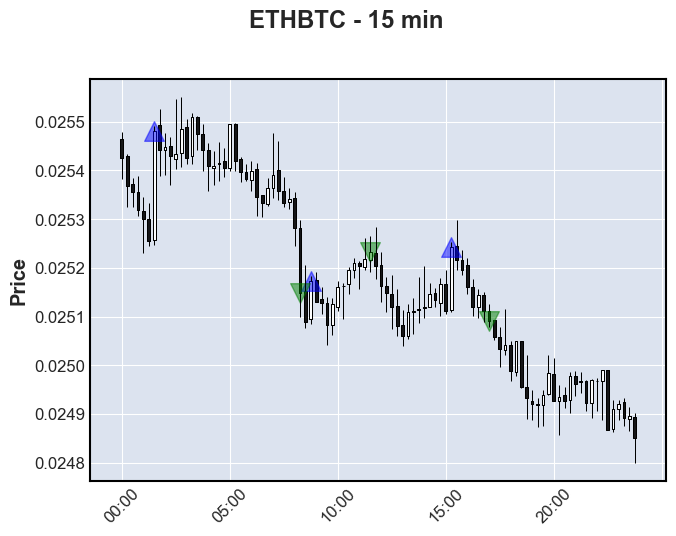

In [26]:
import mplfinance as mpf
import matplotlib.pyplot as plt

def plot_buy_sells(df):
    
    def build_subplot(df, idxs=[]):
        signals = pd.Series(np.NaN, index=df.index)
        prices = df.loc[idxs]['close'].values
        for i,p in zip(idxs,prices):
            signals.at[i]=p
        return signals
    
    decisions = df.trade_decision
    
    buy_signal = build_subplot(df, decisions[decisions==1].index)
    sell_signal = build_subplot(df, decisions[decisions==-1].index)
    
    
    apds=[mpf.make_addplot(buy_signal, type='scatter', markersize=200, marker='^',color='b', alpha=0.5),
          mpf.make_addplot(sell_signal, type='scatter', markersize=200, marker='v',color='g', alpha=0.5),
         ]

    fig, ax = mpf.plot(df,
                       type='candlestick',
                       title=f"ETHBTC - 15 min",
                       returnfig=True,
                       addplot=apds,
                      )
    
    return fig,ax

plot_buy_sells(df.loc['2021-01-01'])